How Weather Impacts Traffic Collisions in the City of Waterloo

Group 5

Members:

Midushaa Kunapalan

Leocyr Cortez Ramos

Muhammad Muddassir

Malcolm O'brien

Malakhai Thompson

Mark Watts


In [59]:
# This is my work on the Group Assignment for Foundations of Data Science, This work contains contributions & code from other members of my group
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
severity_map = {
    'P.D. only': 1,
    'Non-fatal injury': 2,
    'Fatal injury': 3,
    'Other': np.nan,
    'unknown': np.nan,
    'Non-reportable': np.nan
}
# Base URL for the weather data API
base_url = "https://api.weather.gc.ca/collections/climate-hourly/items"
# Define the query parameters except offset (they must be URL-encoded as needed)
params = {
    "f": "json",
    "lang": "en-CA",
    "limit": 50000,  # maximum items per page
    "additionalProp1": "{}",
    "skipGeometry": "false",
    "datetime": "2016-01-01T00:00:00Z/2021-12-31T12:31:12Z",
    "CLIMATE_IDENTIFIER": "6144239"
}

climateList = []
offset = 0

while True:
    # Update the offset for pagination
    params["offset"] = offset
    r = requests.get(base_url, params=params)
    data = r.json()

    # Check how many features were returned
    features = data.get("features", [])
    if not features:
        break  # No more data, so exit the loop

    # Append each record's properties to the list
    for record in features:
        climateList.append(record["properties"])

    # Increase the offset by the limit to get the next page
    offset += params["limit"]

# Create a DataFrame from the collected data
dfweather_raw = pd.DataFrame(climateList)
dfweather_raw['HOUR'] = pd.to_datetime(dfweather_raw['LOCAL_DATE']).dt.hour

print(dfweather_raw)
print(dfweather_raw.columns)
print(dfweather_raw['WEATHER_ENG_DESC'])


       VISIBILITY WEATHER_ENG_DESC           LOCAL_DATE STATION_PRESSURE_FLAG  \
0            16.1               NA  2016-01-01 00:00:00                  None   
1            14.5               NA  2016-01-01 01:00:00                  None   
2            16.1               NA  2016-01-01 02:00:00                  None   
3            16.1               NA  2016-01-01 03:00:00                  None   
4            16.1             Snow  2016-01-01 04:00:00                  None   
...           ...              ...                  ...                   ...   
52551        16.1             Snow  2021-11-22 09:00:00                  None   
52552        16.1             Snow  2021-11-23 08:00:00                  None   
52553        16.1               NA  2021-11-23 09:00:00                  None   
52554        16.1               NA  2021-12-12 00:00:00                  None   
52555        16.1               NA  2021-12-15 12:00:00                  None   

       PRECIP_AMOUNT  UTC_M

In [60]:
base_url = "https://services1.arcgis.com/qAo1OsXi67t7XgmS/arcgis/rest/services/Traffic_Collisions/FeatureServer/0/query"
CollisionList = []

# For each year, page through results
for year in range(2016, 2022):
    offset = 0
    while True:
        # Build URL with pagination parameters: resultOffset and resultRecordCount
        collision_url = (
            f"{base_url}?where=ACCIDENT_YEAR={year}"
            f"&outFields=*"
            f"&returnGeometry=false"
            f"&resultOffset={offset}"
            f"&resultRecordCount=1000"  # adjust count if needed
            f"&f=json"
        )
        r = requests.get(collision_url)
        y = r.json()
        features = y.get("features", [])
        if not features:
            break  # No more records for this year
        for record in features:
            CollisionList.append(record["attributes"])
        offset += 1000  # Move to next page

dfcollisions_raw = pd.DataFrame(CollisionList)
print(dfcollisions_raw.shape)
print(dfcollisions_raw.head())
dfcollisions_raw.info

(7092, 40)
   OBJECTID ACCIDENTNUM   ACCIDENTDATE  ACCIDENT_YEAR  ACCIDENT_MONTH  \
0     44757   16-000325  1451651460000           2016               1   
1     44758   16-000330  1451610000000           2016               1   
2     44759   16-000393  1451652600000           2016               1   
3     44760   16-000423  1451661900000           2016               1   
4     44761   16-000511  1451672400000           2016               1   

   ACCIDENT_DAY  ACCIDENT_HOUR  ACCIDENT_MINUTE  ACCIDENT_SECOND  \
0             1             12               31                0   
1             1              1                0                0   
2             1             12               50                0   
3             1             15               25                0   
4             1             18               20                0   

  ACCIDENT_WEEKDAY  ...  PEDESTRIANINVOLVED  CYCLISTINVOLVED  \
0           Friday  ...               False            False   
1           F

<bound method DataFrame.info of       OBJECTID ACCIDENTNUM   ACCIDENTDATE  ACCIDENT_YEAR  ACCIDENT_MONTH  \
0        44757   16-000325  1451651460000           2016               1   
1        44758   16-000330  1451610000000           2016               1   
2        44759   16-000393  1451652600000           2016               1   
3        44760   16-000423  1451661900000           2016               1   
4        44761   16-000511  1451672400000           2016               1   
...        ...         ...            ...            ...             ...   
7087     52381   503028520  1634571600000           2021              10   
7088     52382   503056778  1636616040000           2021              11   
7089     52383   503098443  1640544300000           2021              12   
7090     52384   503098587  1640607000000           2021              12   
7091     52385   503098756  1640613600000           2021              12   

      ACCIDENT_DAY  ACCIDENT_HOUR  ACCIDENT_MINUTE  ACC

In [61]:
# To see all unique accident years
unique_years = dfcollisions_raw['ACCIDENT_YEAR'].unique()
print("Unique accident years:", unique_years)

# Alternatively, print the minimum and maximum accident year to get the range
min_year = dfcollisions_raw['ACCIDENT_YEAR'].min()
max_year = dfcollisions_raw['ACCIDENT_YEAR'].max()
print("Accidents from year", min_year, "to", max_year)
dfweather_raw['LOCAL_DATE'] = pd.to_datetime(dfweather_raw['LOCAL_DATE']) # Now dfweather_raw is defined

# Check that required columns exist (including ACCIDENT_HOUR)
required_cols = ['ACCIDENT_YEAR', 'ACCIDENT_MONTH', 'ACCIDENT_DAY', 'ACCIDENT_HOUR']
for col in required_cols:
    if col not in dfcollisions_raw.columns:
        raise ValueError(f"Column '{col}' is missing in dfcollisions_raw")

# Convert these columns to numeric
for col in required_cols:
    dfcollisions_raw[col] = pd.to_numeric(dfcollisions_raw[col], errors='coerce')

# Create the ACCIDENT_DATETIME column in one step by combining year, month, day, and hour.
# We use string concatenation and ensure that month, day, and hour are two digits (using zfill)
dfcollisions_raw['ACCIDENT_DATETIME'] = pd.to_datetime(
    dfcollisions_raw['ACCIDENT_YEAR'].astype(str) + '-' +
    dfcollisions_raw['ACCIDENT_MONTH'].astype(str).str.zfill(2) + '-' +
    dfcollisions_raw['ACCIDENT_DAY'].astype(str).str.zfill(2) + ' ' +
    dfcollisions_raw['ACCIDENT_HOUR'].astype(str).str.zfill(2) + ':00:00',
    errors='coerce'
)

# Print info about the new column to verify everything
dfcollisions_raw.info()
print(dfcollisions_raw[['ACCIDENT_DATETIME', 'ACCIDENT_YEAR', 'ACCIDENT_MONTH', 'ACCIDENT_DAY', 'ACCIDENT_HOUR']].head())


Unique accident years: [2016 2017 2018 2019 2020 2021]
Accidents from year 2016 to 2021
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7092 entries, 0 to 7091
Data columns (total 41 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   OBJECTID                     7092 non-null   int64         
 1   ACCIDENTNUM                  7092 non-null   object        
 2   ACCIDENTDATE                 7092 non-null   int64         
 3   ACCIDENT_YEAR                7092 non-null   int64         
 4   ACCIDENT_MONTH               7092 non-null   int64         
 5   ACCIDENT_DAY                 7092 non-null   int64         
 6   ACCIDENT_HOUR                7092 non-null   int64         
 7   ACCIDENT_MINUTE              7092 non-null   int64         
 8   ACCIDENT_SECOND              7092 non-null   int64         
 9   ACCIDENT_WEEKDAY             7092 non-null   object        
 10  XCOORD              

In [62]:
# Round weather times to the hour
dfweather_raw['HOUR_DATETIME'] = dfweather_raw['LOCAL_DATE'].dt.floor('h')

# Merge collision data with nearest weather hour
df_merged = pd.merge(
    dfcollisions_raw,
    dfweather_raw,
    left_on='ACCIDENT_DATETIME',
    right_on='HOUR_DATETIME',
    how='left'
)

In [63]:
df_merged.info

<bound method DataFrame.info of       OBJECTID ACCIDENTNUM   ACCIDENTDATE  ACCIDENT_YEAR  ACCIDENT_MONTH  \
0        44757   16-000325  1451651460000           2016               1   
1        44758   16-000330  1451610000000           2016               1   
2        44759   16-000393  1451652600000           2016               1   
3        44760   16-000423  1451661900000           2016               1   
4        44761   16-000511  1451672400000           2016               1   
...        ...         ...            ...            ...             ...   
7087     52381   503028520  1634571600000           2021              10   
7088     52382   503056778  1636616040000           2021              11   
7089     52383   503098443  1640544300000           2021              12   
7090     52384   503098587  1640607000000           2021              12   
7091     52385   503098756  1640613600000           2021              12   

      ACCIDENT_DAY  ACCIDENT_HOUR  ACCIDENT_MINUTE  ACC

In [64]:
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
#checking total number of accidents/weather types
print(df_merged['WEATHER_ENG_DESC'].unique())
weather_counts = df_merged['WEATHER_ENG_DESC'].value_counts()
print(weather_counts)
sum(weather_counts)
#NaN is listed above in weather counts, how many are there?
nan_count = df_merged['WEATHER_ENG_DESC'].isna().sum()
print(f"Number of NaN values in 'WEATHER_ENG_DESC': {nan_count}")
# how to address these? - there is already an N/A category - assign to there?
df_merged['WEATHER_ENG_DESC'] = df_merged['WEATHER_ENG_DESC'].fillna('NA')
# redo previous calculation
print(df_merged['WEATHER_ENG_DESC'].unique())
weather_counts = df_merged['WEATHER_ENG_DESC'].value_counts()
print(weather_counts)
sum(weather_counts)

['Snow' 'NA' 'Fog' 'Rain' 'Rain,Fog' 'Moderate Snow' 'Rain,Snow'
 'Freezing Fog' 'Thunderstorms,Rain' 'Freezing Rain,Fog' 'Haze'
 'Moderate Rain,Fog' 'Moderate Rain' 'Heavy Snow'
 'Heavy Snow,Blowing Snow' 'Thunderstorms' nan
 'Thunderstorms,Heavy Rain,Fog' 'Moderate Rain,Snow' 'Freezing Rain'
 'Thunderstorms,Moderate Rain,Fog' 'Heavy Rain,Fog'
 'Thunderstorms,Rain,Fog']
WEATHER_ENG_DESC
NA                                 5056
Snow                               1013
Fog                                 354
Rain                                311
Rain,Fog                            211
Moderate Snow                        32
Haze                                 25
Moderate Rain,Fog                    19
Thunderstorms                        12
Freezing Fog                         10
Thunderstorms,Rain                    9
Freezing Rain,Fog                     7
Moderate Rain                         5
Rain,Snow                             4
Moderate Rain,Snow                    3
Freezing 

7092

In [65]:
# Isolate the accidents occurring by any types of snowy weather
snow_df=df_merged[df_merged['WEATHER_ENG_DESC'].str.contains('snow|freezing', case=False, na=False)]
snow_df.info
month_counts = snow_df.groupby('ACCIDENT_MONTH').size().reset_index(name='CollisionCount')

#Below are graphs and visualizations used to examine relationships of weather and accidents

#plt.figure(figsize=(10, 6))
#sns.barplot(x='ACCIDENT_MONTH', y='CollisionCount', data=month_counts, palette="pastel", hue='ACCIDENT_MONTH')
#plt.title("Snowy Weather Collision Frequency by Month")
#plt.xlabel("Month")
#plt.ylabel("Number of Collisions")
#plt.show()
#plt.figure(figsize=(10, 6))
#SW=sns.histplot(data=snow_df, x='ACCIDENT_MONTH', palette="deep" , hue='WEATHER_ENG_DESC', multiple='stack', discrete=True)
#plt.title("Plot of Collisions by Month and Type of Snowy Conditions")
#plt.xlabel("Month of Accident")
#plt.ylabel("Number of Collisions")
#sns.move_legend(SW, "upper left", bbox_to_anchor=(1, 1))
#plt.show()
#plt.figure(figsize=(10, 6))
#sns.countplot(x='ACCIDENT_WEEKDAY', data=snow_df, palette="rocket", hue='ACCIDENT_WEEKDAY', order = days_of_week)
#plt.title("Snowy Condition Collisions by Day of the Week Total")
#plt.xlabel("Day")
#plt.ylabel("Number of Collisions")
#plt.show()
filtered_df=df_merged[~df_merged['WEATHER_ENG_DESC'].str.contains('snow|freezing', case=False, na=False)]


#plt.figure(figsize=(10, 6))
#NSW=sns.histplot(data=filtered_df, x='ACCIDENT_MONTH', palette="deep" , hue='WEATHER_ENG_DESC', multiple='stack', discrete=True)
#plt.title("Plot of Collisions by Month and Environmental Condition, Excluding Snowy and/or Freezing Weather")
#plt.xlabel("Month of Accident")
#plt.ylabel("Number of Collisions")
#sns.move_legend(NSW, "upper left", bbox_to_anchor=(1, 1))
#plt.show()
#plt.figure(figsize=(10, 6))
#sns.countplot(x='ACCIDENT_HOUR', data=snow_df , palette="rocket")
#plt.title("Collisions by Hour in Snowy Conditions")
#plt.xlabel("Hour of Day")
#plt.ylabel("Number of Collisions")
#plt.show()
#plt.figure(figsize=(10, 6))
#sns.countplot(x='ACCIDENT_HOUR', data=df_merged, palette="rocket")
#plt.title("Collisions by Hour Total")
#plt.xlabel("Hour of Day")
#plt.ylabel("Number of Collisions")
#plt.show()
#hourly distribution of accidents shows a great variance by hour - use hourly accident numbers to normalize for weather conditions?




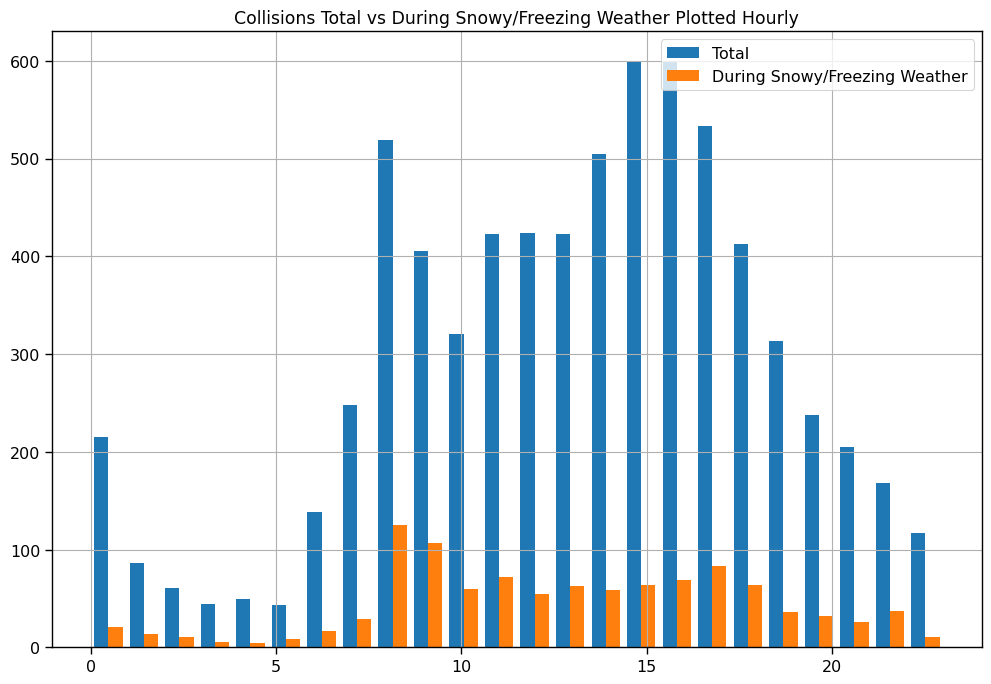

In [66]:
plt.figure(figsize=(12, 8))
x = df_merged['ACCIDENT_HOUR']
y = snow_df['ACCIDENT_HOUR']
sns.set_context("paper", font_scale=1.3)

plt.hist([x, y], bins=24, label=['Total ', 'During Snowy/Freezing Weather']) 
plt.grid(True)
plt.legend(loc='upper right')
plt.title("Collisions Total vs During Snowy/Freezing Weather Plotted Hourly")
plt.show()

# difference in distribution of accidents in winter conditions vs total hourly - not a direct correlation - spike around afternoon rush hour not matched in orange
# higher percentage of winter driving conditions in morning vs afternoon? - check for total number of winter weather counts in each hour -



In [67]:
#start by finding breakdown % of types of weather of total recorded weather
total_weather_counts = dfweather_raw['WEATHER_ENG_DESC'].value_counts()
total_weather_hours = total_weather_counts.sum()
print(total_weather_counts)
print(sum(total_weather_counts))

#put in Data frame to keep for reference
weather_type_distribution = pd.DataFrame({
    'Weather Types': dfweather_raw['WEATHER_ENG_DESC'].unique(),
    'Total Weather Types': total_weather_counts,
    'Percent for type of Total': (total_weather_counts / total_weather_hours) * 100
})


# Calculate the percentage of total hours with Snowy and/or Freezing conditions
snow_freezing_conditions = weather_type_distribution['Weather Types'].str.contains('snow|freezing', case=False, na=False)
snow_freezing_percentage = weather_type_distribution.loc[snow_freezing_conditions, 'Percent for type of Total'].sum()
print('The total % of hours of Snowy and/or Freezing conditions is: ', snow_freezing_percentage.round(2), ' %')

# Calculate the percentage of total hours where any type of weather is listed 
weather_conditions = weather_type_distribution[~weather_type_distribution['Weather Types'].str.contains('NA', case=False, na=False)]
weather_conditions_percentage = weather_conditions['Percent for type of Total'].sum()
print('The total % of hours of any weather conditions is: ', weather_conditions_percentage.round(2), ' %')



WEATHER_ENG_DESC
NA                                 39626
Snow                                4333
Fog                                 4060
Rain                                2148
Rain,Fog                            1575
Moderate Rain,Fog                    146
Haze                                 145
Freezing Fog                          81
Thunderstorms,Rain                    59
Heavy Snow                            52
Thunderstorms                         50
Moderate Snow                         47
Rain,Snow                             41
Moderate Rain                         37
Freezing Rain,Fog                     28
Heavy Rain,Fog                        26
Freezing Rain                         21
Thunderstorms,Rain,Fog                19
Thunderstorms,Heavy Rain,Fog          19
Thunderstorms,Moderate Rain,Fog       10
Freezing Rain,Snow                     7
Thunderstorms,Moderate Rain            6
Thunderstorms,Fog                      4
Thunderstorms,Heavy Rain               4

In [68]:
# create a data frame of accidents with any listed weather conditions
weat_df=df_merged[~df_merged['WEATHER_ENG_DESC'].str.contains('NA', case=False, na=False)]
print(weat_df)


      OBJECTID ACCIDENTNUM   ACCIDENTDATE  ACCIDENT_YEAR  ACCIDENT_MONTH  \
0        44757   16-000325  1451651460000           2016               1   
2        44759   16-000393  1451652600000           2016               1   
4        44761   16-000511  1451672400000           2016               1   
5        44762   16-000523  1451674200000           2016               1   
6        44763   16-000912  1451678400000           2016               1   
...        ...         ...            ...            ...             ...   
7070     52318    22173215  1637656200000           2021              11   
7071     52365   502957571  1614679200000           2021               3   
7086     52380    50302655  1628744400000           2021               8   
7090     52384   503098587  1640607000000           2021              12   
7091     52385   503098756  1640613600000           2021              12   

      ACCIDENT_DAY  ACCIDENT_HOUR  ACCIDENT_MINUTE  ACCIDENT_SECOND  \
0               

In [69]:
# check accidents during weather conditions(snowy & all) vs expected values assuming an even distribution of accidents across all conditions
#total accidents
total_accidents=len(dfcollisions_raw)
print('The Total number of accidents in the 5 year data set is', total_accidents)
# expected # of accidents during snowy weather is 15.9%
even_dist_snow_acc=(total_accidents*(snow_freezing_percentage/100))
print('The total % of hours of Snowy and/or Freezing conditions is: ', snow_freezing_percentage, ' %')
print('The expected # of accidents to occur during Snowy & Freezing conditions (assuming weather does not affect number of collisions) is ', even_dist_snow_acc.round(0))
# find actual % of accidents occurring during snowy & freezing conditions
print('The actual % of accidents that occurred during snowy & freezing conditions is ', len(snow_df))

# expected # of accidents during any weather is 24.6%
even_dist_weat_acc=(total_accidents*(weather_conditions_percentage/100))
print('The total % of hours of any listed weather conditions is: ', weather_conditions_percentage, ' %')
print('The expected # of accidents to occur during any listed weather conditions (assuming weather does not affect number of collisions) is ', even_dist_weat_acc.round(0))
# find actual % of accidents occurring during any listed weather conditions
print('The actual % of accidents that occurred during any listed weather conditions is ', len(weat_df))

The Total number of accidents in the 5 year data set is 7092
The total % of hours of Snowy and/or Freezing conditions is:  15.903036760788492  %
The expected # of accidents to occur during Snowy & Freezing conditions (assuming weather does not affect number of collisions) is  1128.0
The actual % of accidents that occurred during snowy & freezing conditions is  1075
The total % of hours of any listed weather conditions is:  24.60232894436411  %
The expected # of accidents to occur during any listed weather conditions (assuming weather does not affect number of collisions) is  1745.0
The actual % of accidents that occurred during any listed weather conditions is  2026


In [70]:
# with a slightly higher incidence of accidents during any weather condition it is assumed that the weather conditions negatively affected driving conditions
# though a slightly lower incidence of accidents during wintery weather it contradicts this - 
#possible reasons for this - winter conditions cause less traffic - people may drive more carefully in the worst weather - incidences of bad winter weather
# may occur predominantly outside of prime driving times - sample set of winter accidents may be too small for inference or deduction
# TESTS FOR clarity in cell 32 results
# check sample sizes - 52556 hours of weather snapshots - 7092 accidents across those same 5 years
# apply across an hourly distribution to check time of day (& assumed traffic volumes) for impact between weather and nonweather accident percentages
# apply across a monthly distribution for relation between winter & summer weather & nonweather?
dfweather_raw['HOUR_DATETIME'] = dfweather_raw['LOCAL_DATE'].dt.floor('h')

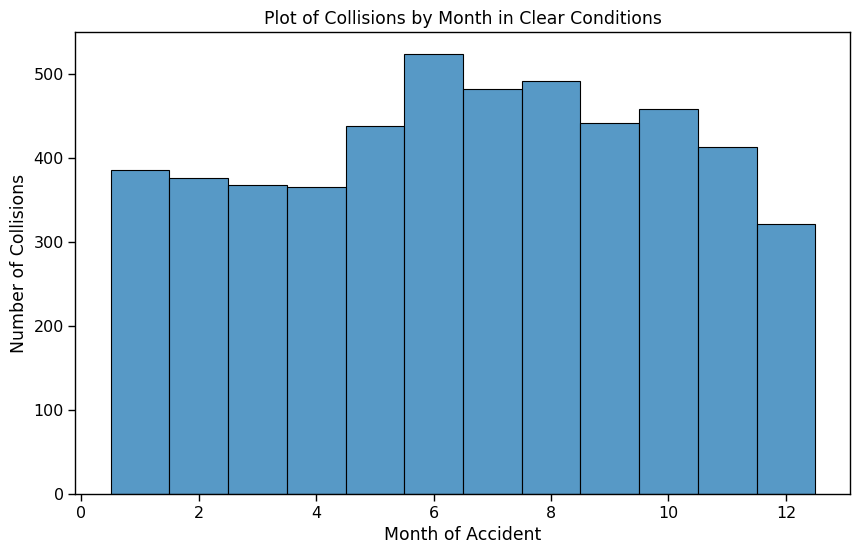

In [71]:
#plot accidents in clear weather only by month
clear_weather_accidents = df_merged[df_merged['WEATHER_ENG_DESC'].str.contains('NA', case=False, na=False)]

plt.figure(figsize=(10, 6))
CWA=sns.histplot(data=clear_weather_accidents, x='ACCIDENT_MONTH',   discrete=True)
plt.title("Plot of Collisions by Month in Clear Conditions")
plt.xlabel("Month of Accident")
plt.ylabel("Number of Collisions")

plt.show()

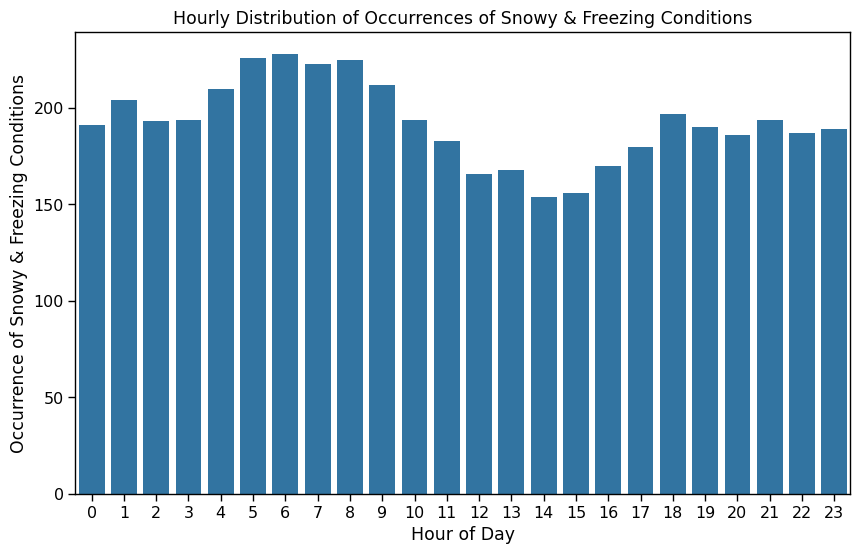

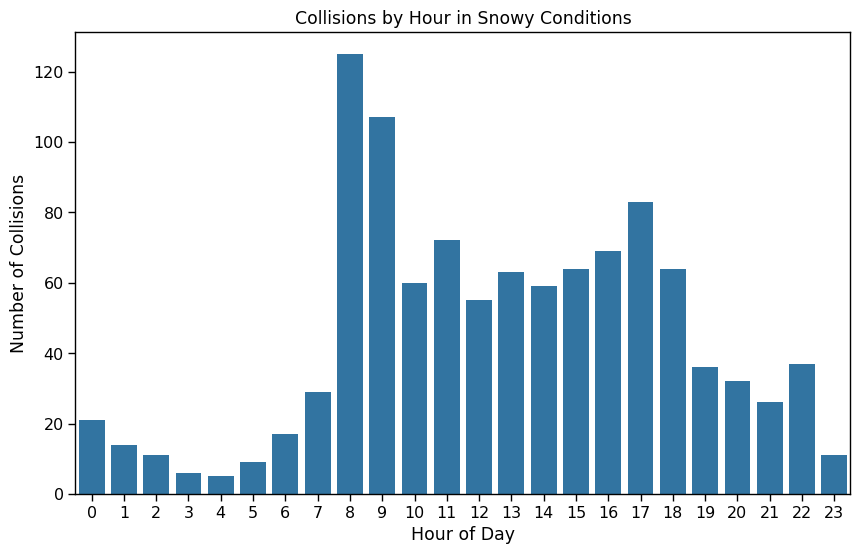

In [72]:
#hourly distribution of winter weather occurrences - looking for winter weather occurring outside of high traffic driving times
total_winter_weather = dfweather_raw[dfweather_raw['WEATHER_ENG_DESC'].str.contains('snow|freezing', case=False, na=False)]
plt.figure(figsize=(10, 6))
sns.countplot(x='HOUR', data=total_winter_weather)
plt.title("Hourly Distribution of Occurrences of Snowy & Freezing Conditions")
plt.xlabel("Hour of Day")
plt.ylabel("Occurrence of Snowy & Freezing Conditions")
plt.show()



#winter weather accidents by time of day
plt.figure(figsize=(10, 6))
sns.countplot(x='ACCIDENT_HOUR', data=snow_df )
plt.title("Collisions by Hour in Snowy Conditions")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Collisions")
plt.show()

# graphed occurrence of winter weather & hour of day vs winter accidents and time of day
#Graph relationship between these two


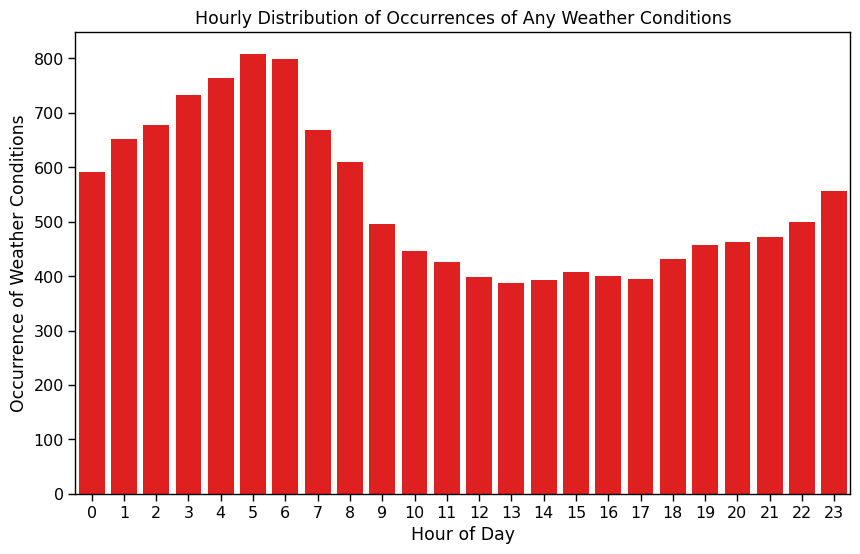

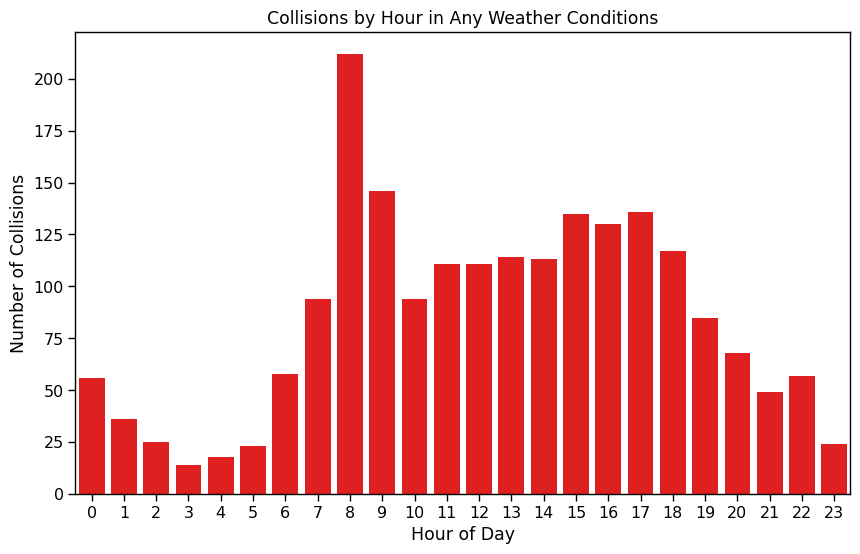

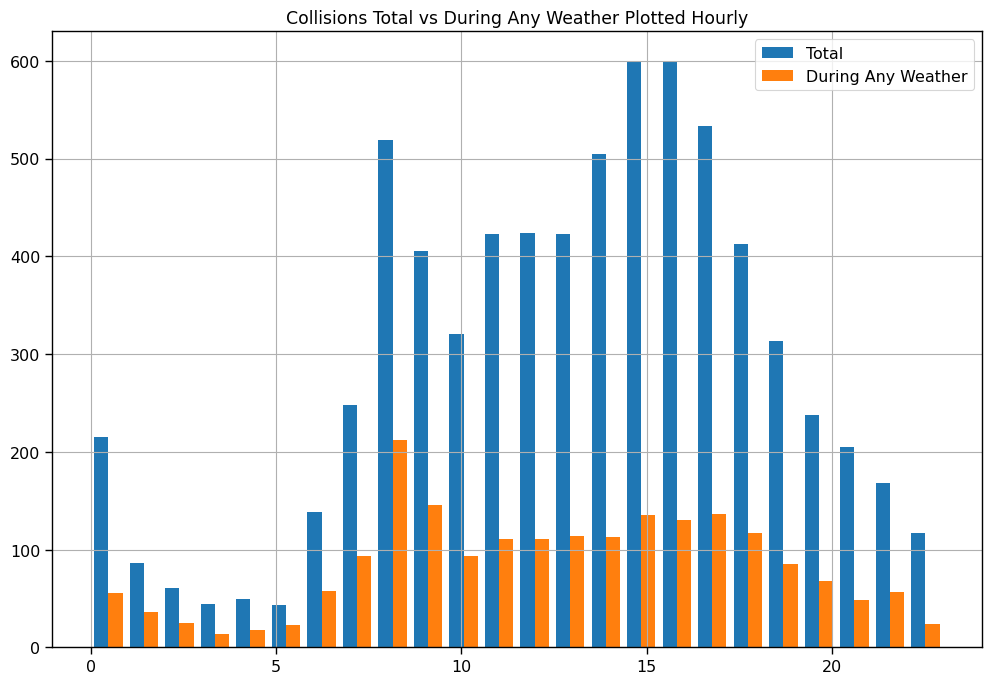

In [73]:
#hourly distribution of  weather occurrences - to use as a comparison vs winter weather or test hypothesis
total_weather = dfweather_raw[~dfweather_raw['WEATHER_ENG_DESC'].str.contains('NA', case=False, na=False)]
plt.figure(figsize=(10, 6))
sns.countplot(x='HOUR', data=total_weather, color='r')
plt.title("Hourly Distribution of Occurrences of Any Weather Conditions")
plt.xlabel("Hour of Day")
plt.ylabel("Occurrence of Weather Conditions")
plt.show()


# All weather accidents by time of day

plt.figure(figsize=(10, 6))
sns.countplot(x='ACCIDENT_HOUR', data=weat_df, color='r')
plt.title("Collisions by Hour in Any Weather Conditions")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Collisions")
plt.show()

# show both in the same graph
plt.figure(figsize=(12, 8))
x = df_merged['ACCIDENT_HOUR']
y = weat_df['ACCIDENT_HOUR']
sns.set_context("paper", font_scale=1.3)

plt.hist([x, y], bins=24, label=['Total ', 'During Any Weather']) 
plt.grid(True)
plt.legend(loc='upper right')
plt.title("Collisions Total vs During Any Weather Plotted Hourly")
plt.show()


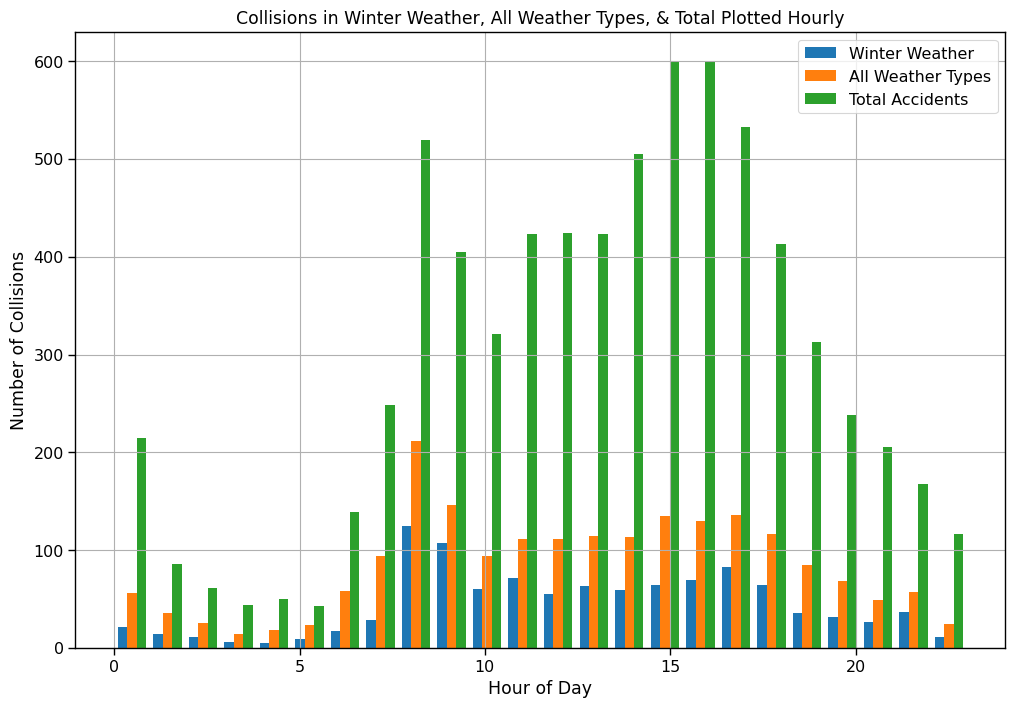

In [74]:
#compare winter weather to all weather types hourly & accidents hourly
# show both in the same graph
plt.figure(figsize=(12, 8))
x = snow_df['ACCIDENT_HOUR']
y = weat_df['ACCIDENT_HOUR']
z = df_merged['ACCIDENT_HOUR']
sns.set_context("paper", font_scale=1.3)

plt.hist([x, y, z], bins=24, label=['Winter Weather ', 'All Weather Types', 'Total Accidents']) 
plt.grid(True)
plt.legend(loc='upper right')
plt.title("Collisions in Winter Weather, All Weather Types, & Total Plotted Hourly")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Collisions")
plt.show()

In [75]:
#create a column of df_merged to normalize accidents as %
def categorize_weather(weather_desc):
    
    if weather_desc == 'NA':
        return 'good'
    else:
        return 'inclement'
df_merged['WEATHER_CATEGORY'] = df_merged['WEATHER_ENG_DESC'].apply(categorize_weather)
print(df_merged[['WEATHER_ENG_DESC', 'WEATHER_CATEGORY']].head())

  WEATHER_ENG_DESC WEATHER_CATEGORY
0             Snow        inclement
1               NA             good
2             Snow        inclement
3               NA             good
4             Snow        inclement


<Figure size 1200x800 with 0 Axes>

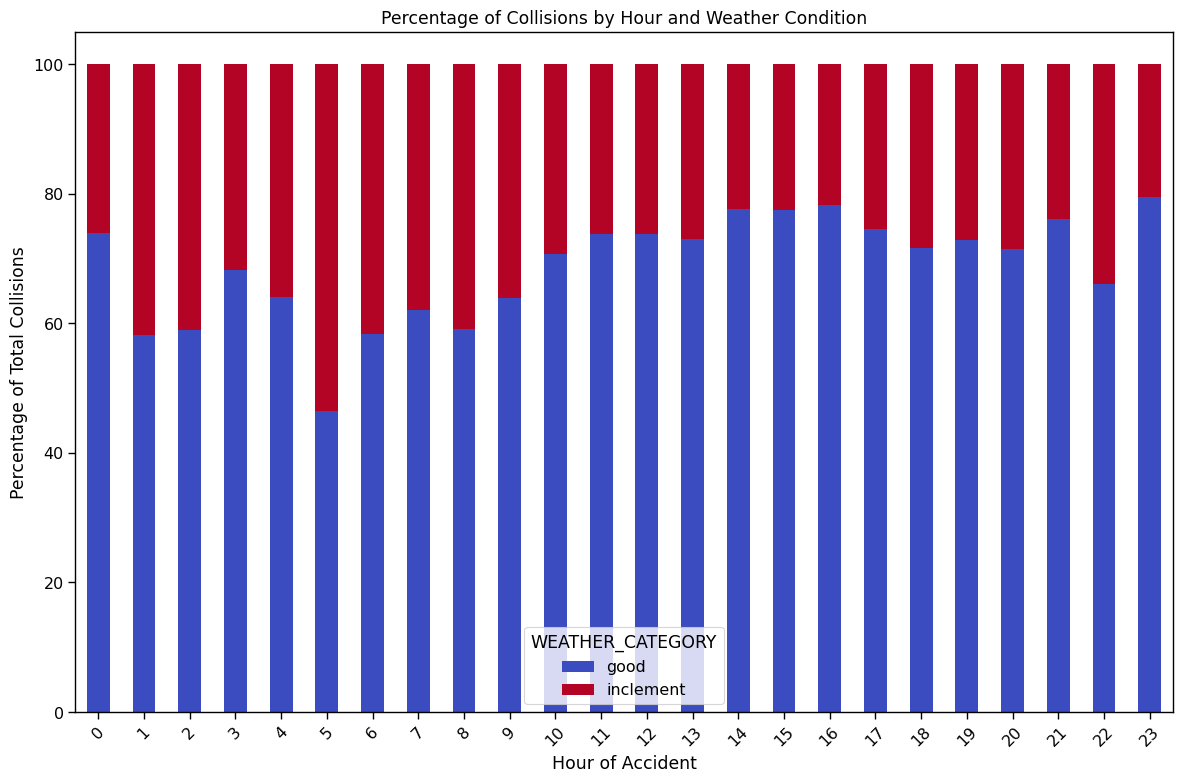

In [76]:
df_plot = df_merged.groupby(['ACCIDENT_HOUR', 'WEATHER_CATEGORY']).size().reset_index(name='CollisionCount')

# Normalize the 'CollisionCount' to get percentages
df_plot['Percentage'] = df_plot.groupby('ACCIDENT_HOUR')['CollisionCount'].transform(lambda x: x / x.sum() * 100)

# Create a pivot table to prepare the data for a stacked bar plot
df_pivot = df_plot.pivot(index='ACCIDENT_HOUR', columns='WEATHER_CATEGORY', values='Percentage')

# Plotting the stacked bar chart
plt.figure(figsize=(12, 8))

df_pivot.plot(kind='bar', stacked=True, figsize=(12, 8), colormap="coolwarm")

plt.title("Percentage of Collisions by Hour and Weather Condition")
plt.xlabel("Hour of Accident")
plt.ylabel("Percentage of Total Collisions")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<Figure size 1200x800 with 0 Axes>

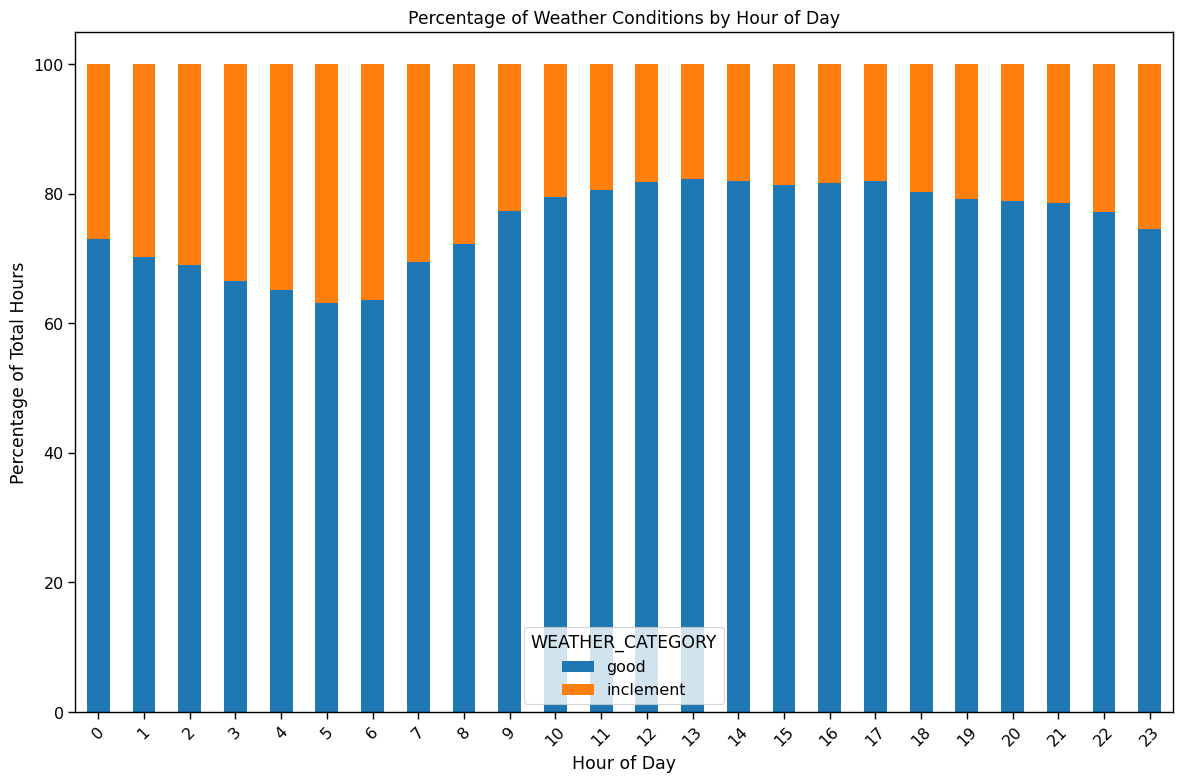

In [77]:
def categorize_weather(weather_desc):
    
    if weather_desc == 'NA':
        return 'good'
    else:
        return 'inclement'
        
dfweather_raw['WEATHER_CATEGORY'] = dfweather_raw['WEATHER_ENG_DESC'].apply(categorize_weather)
dfweather_plot =dfweather_raw.groupby(['HOUR', 'WEATHER_CATEGORY']).size().reset_index(name='WeatherCount')

# Normalize the 'WeatherCount' to get percentages
dfweather_plot['Percentage'] = dfweather_plot.groupby('HOUR')['WeatherCount'].transform(lambda x: x / x.sum() * 100)

# Create a pivot table to prepare the data for a stacked bar plot
dfweather_pivot = dfweather_plot.pivot(index='HOUR', columns='WEATHER_CATEGORY', values='Percentage')

plt.figure(figsize=(12, 8))
dfweather_pivot.plot(kind='bar', stacked=True, figsize=(12, 8))
plt.title("Percentage of Weather Conditions by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Percentage of Total Hours")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [78]:
#show both % of accidents and good weather in same chart

# Create a pivot table to prepare the data for a stacked bar plot
dfcombined_pivot = pd.merge(df_pivot, dfweather_pivot, left_index=True, right_index=True)
dfcombined_pivot.info


<bound method DataFrame.info of WEATHER_CATEGORY     good_x  inclement_x     good_y  inclement_y
ACCIDENT_HOUR                                                   
0                 73.953488    26.046512  72.980374    27.019626
1                 58.139535    41.860465  70.287540    29.712460
2                 59.016393    40.983607  69.055226    30.944774
3                 68.181818    31.818182  66.605839    33.394161
4                 64.000000    36.000000  65.145985    34.854015
5                 46.511628    53.488372  63.138686    36.861314
6                 58.273381    41.726619  63.594891    36.405109
7                 62.096774    37.903226  69.479927    30.520073
8                 59.152216    40.847784  72.171533    27.828467
9                 63.950617    36.049383  77.351598    22.648402
10                70.716511    29.283489  79.532967    20.467033
11                73.758865    26.241135  80.512351    19.487649
12                73.820755    26.179245  81.739130    18.

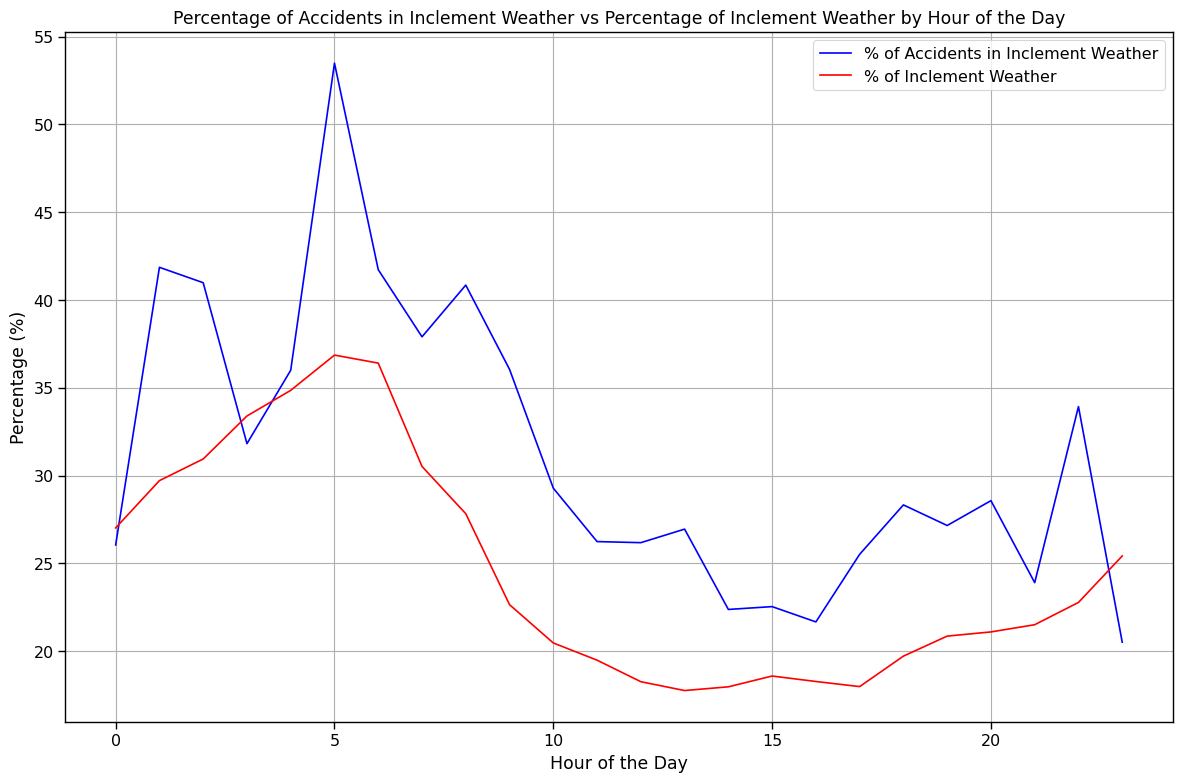

In [79]:
plt.figure(figsize=(12, 8))

# Plot inclement_x (accidents in inclement weather)
sns.lineplot(x=dfcombined_pivot.index, y=dfcombined_pivot['inclement_x'], label='% of Accidents in Inclement Weather', color='blue')

# Plot inclement_y (percentage of inclement weather)
sns.lineplot(x=dfcombined_pivot.index, y=dfcombined_pivot['inclement_y'], label='% of Inclement Weather', color='red')
plt.title("Percentage of Accidents in Inclement Weather vs Percentage of Inclement Weather by Hour of the Day")
plt.xlabel("Hour of the Day")
plt.ylabel("Percentage (%)")
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()

In [80]:
# There is a positive relation between bad weather and accidents plotted across the hours of the day
# there is a higher percentage of bad weather conditions occurring in the evenings and overnight (after the sun is down) but also a slightly spike
#in traffic accidents in the early rush hour in response to the overnight bad weather
# perhaps a delayed bump in accidents when measured against recent (in the last hour or so) bad weather conditions
# maybe someone can graph the relationship more clearly or try an autocorrelation plot? or maybe just a plot time shifted by an hour? 

C:\Users\leocyr\AppData\Local\Temp\ipykernel_26768\1525161325.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  visibility_counts = df_merged.groupby('VISIBILITY_BIN').size().reset_index(name='CollisionCount')
C:\Users\leocyr\AppData\Local\Temp\ipykernel_26768\1525161325.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='VISIBILITY_BIN', y='CollisionCount', data=visibility_counts, palette="viridis")


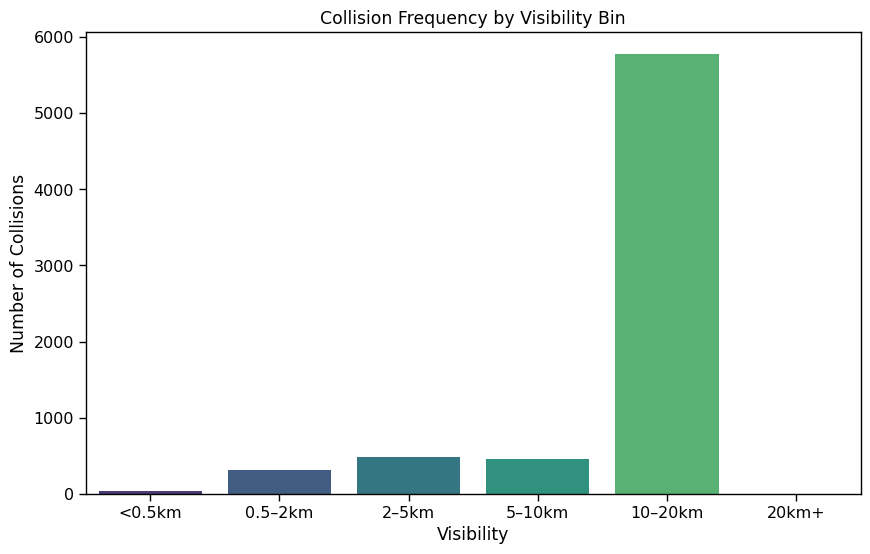

In [81]:
# Create visibility bins – adjust as needed for your region
df_merged['VISIBILITY_BIN'] = pd.cut(df_merged['VISIBILITY'],
                                     bins=[-1, 0.5, 2, 5, 10, 20, 50],
                                     labels=['<0.5km', '0.5–2km', '2–5km', '5–10km', '10–20km', '20km+'])

# Group collisions by visibility bin and count occurrences
visibility_counts = df_merged.groupby('VISIBILITY_BIN').size().reset_index(name='CollisionCount')

# Bar plot of collisions by visibility bin
plt.figure(figsize=(10, 6))
sns.barplot(x='VISIBILITY_BIN', y='CollisionCount', data=visibility_counts, palette="viridis")
plt.title("Collision Frequency by Visibility Bin")
plt.xlabel("Visibility")
plt.ylabel("Number of Collisions")
sns.set_context("paper", font_scale=1.0)
plt.show()


In [82]:
# Suppose dfweather_raw is your weather DataFrame
dfweather_raw['VISIBILITY_BIN'] = pd.cut(
    dfweather_raw['VISIBILITY'],
    bins=[-1, 0.5, 2, 5, 10, 20, 50],
    labels=['<0.5km', '0.5–2km', '2–5km', '5–10km', '10–20km', '20km+']
)

# Hours of weather in each bin
weather_hours = dfweather_raw.groupby('VISIBILITY_BIN').size().reset_index(name='WeatherHours')
print(weather_hours)
total_weather_hours = weather_hours['WeatherHours'].sum()
print(total_weather_hours)

df_merged['VISIBILITY_BIN'] = pd.cut(
    df_merged['VISIBILITY'],
    bins=[-1, 0.5, 2, 5, 10, 20, 50],
    labels=['<0.5km', '0.5–2km', '2–5km', '5–10km', '10–20km', '20km+']
)

collision_counts = df_merged.groupby('VISIBILITY_BIN').size().reset_index(name='CollisionCount')
print(collision_counts)


  VISIBILITY_BIN  WeatherHours
0         <0.5km           584
1        0.5–2km          1505
2          2–5km          3119
3         5–10km          3143
4        10–20km         44122
5          20km+             0
52473
  VISIBILITY_BIN  CollisionCount
0         <0.5km              40
1        0.5–2km             313
2          2–5km             478
3         5–10km             463
4        10–20km            5774
5          20km+               0


C:\Users\leocyr\AppData\Local\Temp\ipykernel_26768\1623725209.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  weather_hours = dfweather_raw.groupby('VISIBILITY_BIN').size().reset_index(name='WeatherHours')
C:\Users\leocyr\AppData\Local\Temp\ipykernel_26768\1623725209.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  collision_counts = df_merged.groupby('VISIBILITY_BIN').size().reset_index(name='CollisionCount')


In [83]:
# Merge the two counts: weather hours and collision counts per visibility bin
# We use an outer merge to include all visibility bins, even if one dataset has zero records for that bin.
df_vis = pd.merge(
    weather_hours,      # DataFrame containing the count of weather observations per visibility bin
    collision_counts,   # DataFrame containing the count of collisions per visibility bin
    on='VISIBILITY_BIN',
    how='outer'
)

# After the merge, some bins might be missing in one of the DataFrames, resulting in NaN values.
# Fill NaN values in both 'CollisionCount' and 'WeatherHours' with 0,
# because if a bin is missing from one DataFrame it means there were 0 records for that bin.
df_vis['CollisionCount'] = df_vis['CollisionCount'].fillna(0)
df_vis['WeatherHours'] = df_vis['WeatherHours'].fillna(0)

# (Optional) If 'VISIBILITY_BIN' had NaNs (unlikely), you could fill them with a category like 'Unknown':
# df_vis['VISIBILITY_BIN'] = df_vis['VISIBILITY_BIN'].cat.add_categories(['Unknown']).fillna('Unknown')

# Calculate the collision rate: number of collisions per 1000 hours of weather data
# This normalizes the collision counts by the amount of time spent in that visibility bin.
df_vis['CollisionsPerThousandHours'] = (df_vis['CollisionCount'] / df_vis['WeatherHours']) * 1000

# Print the resulting DataFrame to review the computed values
print(df_vis)


  VISIBILITY_BIN  WeatherHours  CollisionCount  CollisionsPerThousandHours
0         <0.5km           584              40                   68.493151
1        0.5–2km          1505             313                  207.973422
2          2–5km          3119             478                  153.254248
3         5–10km          3143             463                  147.311486
4        10–20km         44122            5774                  130.864421
5          20km+             0               0                         NaN


C:\Users\leocyr\AppData\Local\Temp\ipykernel_26768\1978105319.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


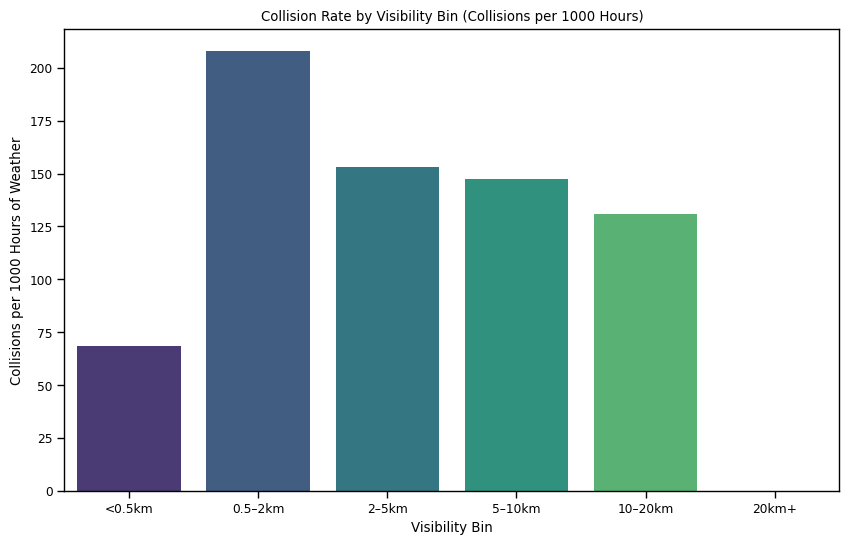

In [84]:

plt.figure(figsize=(10, 6))
sns.barplot(
    x='VISIBILITY_BIN',
    y='CollisionsPerThousandHours',
    data=df_vis,
    palette="viridis"
)
plt.title("Collision Rate by Visibility Bin (Collisions per 1000 Hours)")
plt.xlabel("Visibility Bin")
plt.ylabel("Collisions per 1000 Hours of Weather")
plt.show()


C:\Users\leocyr\AppData\Local\Temp\ipykernel_26768\1877966522.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  precip_counts = df_merged.groupby('PRECIP_BIN').size().reset_index(name='CollisionCount')
C:\Users\leocyr\AppData\Local\Temp\ipykernel_26768\1877966522.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='PRECIP_BIN', y='CollisionCount', data=precip_counts, palette="magma")


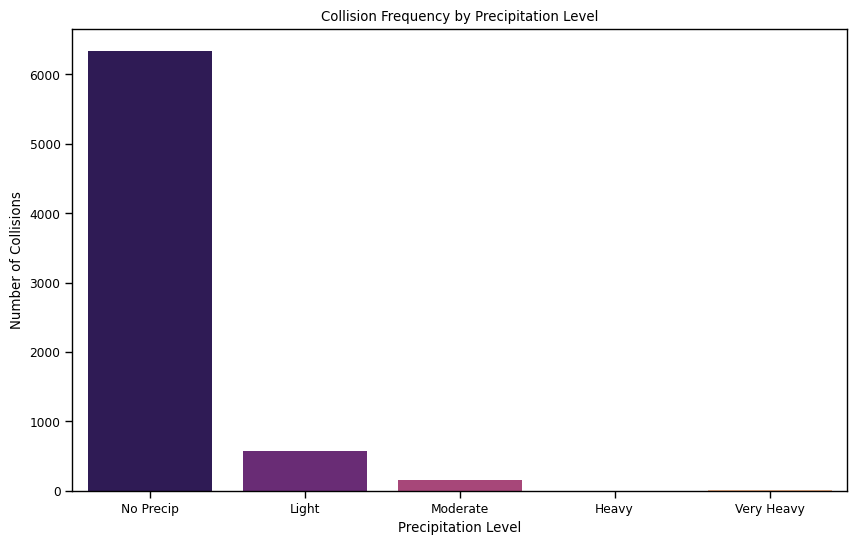

In [85]:
# Create bins for precipitation (assuming PRECIP_AMOUNT is in mm)
df_merged['PRECIP_BIN'] = pd.cut(df_merged['PRECIP_AMOUNT'],
                                 bins=[-0.1, 0, 1, 5, 10, 50],
                                 labels=['No Precip', 'Light', 'Moderate', 'Heavy', 'Very Heavy'])

# Group collisions by precipitation bin
precip_counts = df_merged.groupby('PRECIP_BIN').size().reset_index(name='CollisionCount')

plt.figure(figsize=(10, 6))
sns.barplot(x='PRECIP_BIN', y='CollisionCount', data=precip_counts, palette="magma")
plt.title("Collision Frequency by Precipitation Level")
plt.xlabel("Precipitation Level")
plt.ylabel("Number of Collisions")
plt.show()

C:\Users\leocyr\AppData\Local\Temp\ipykernel_26768\1566098904.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='ACCIDENT_MONTH', y='CollisionCount', data=month_counts, palette="pastel")


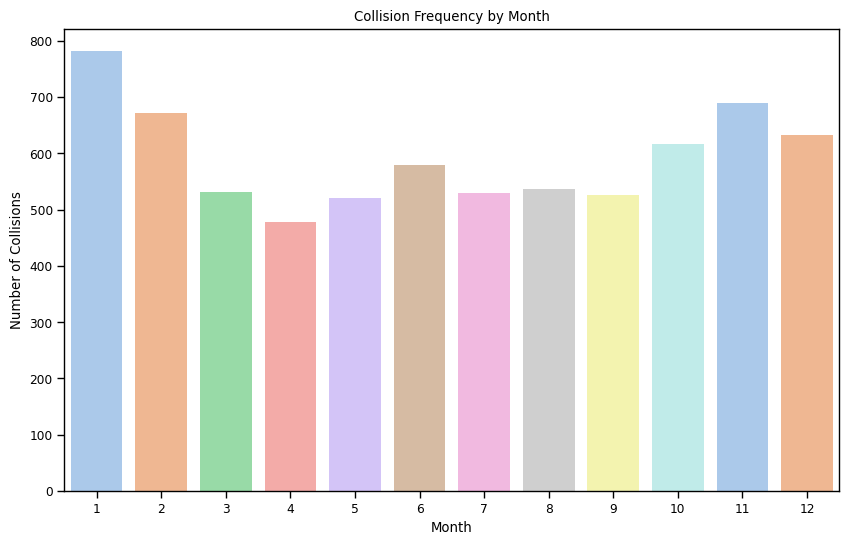

In [86]:
# Assume ACCIDENT_DATETIME exists and is of datetime type
df_merged['ACCIDENT_MONTH'] = df_merged['ACCIDENT_DATETIME'].dt.month

month_counts = df_merged.groupby('ACCIDENT_MONTH').size().reset_index(name='CollisionCount')

plt.figure(figsize=(10, 6))
sns.barplot(x='ACCIDENT_MONTH', y='CollisionCount', data=month_counts, palette="pastel")
plt.title("Collision Frequency by Month")
plt.xlabel("Month")
plt.ylabel("Number of Collisions")
plt.show()

C:\Users\leocyr\AppData\Local\Temp\ipykernel_26768\107972520.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='ACCIDENT_HOUR', data=adverse_conditions, palette="rocket")


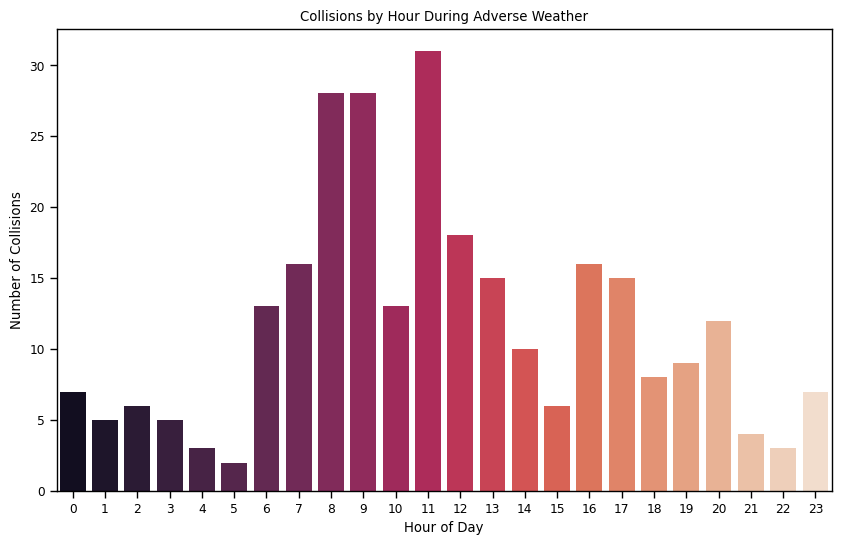

C:\Users\leocyr\AppData\Local\Temp\ipykernel_26768\107972520.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='ACCIDENT_HOUR', data=df_merged, palette="rocket")


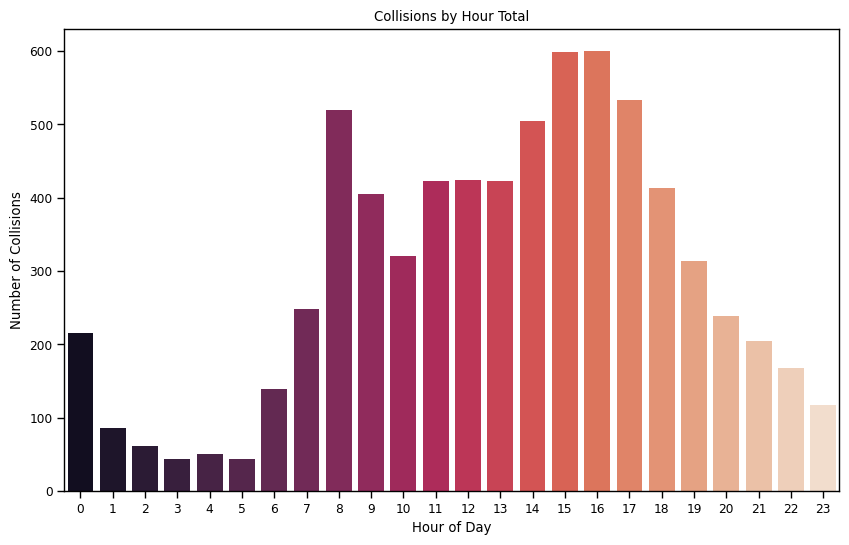

In [87]:
# Create a column for accident hour if not already done:
df_merged['ACCIDENT_HOUR'] = df_merged['ACCIDENT_DATETIME'].dt.hour

# Optionally, filter for adverse weather (e.g., low visibility or heavy precipitation)
adverse_conditions = df_merged[(df_merged['VISIBILITY'] < 2) | (df_merged['PRECIP_AMOUNT'] > 5)]

plt.figure(figsize=(10, 6))
sns.countplot(x='ACCIDENT_HOUR', data=adverse_conditions, palette="rocket")
plt.title("Collisions by Hour During Adverse Weather")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Collisions")
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(x='ACCIDENT_HOUR', data=df_merged, palette="rocket")
plt.title("Collisions by Hour Total")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Collisions")
plt.show()



C:\Users\leocyr\AppData\Local\Temp\ipykernel_26768\1737127901.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='ENVIRONMENTCONDITION1', data=df_merged, palette="viridis")


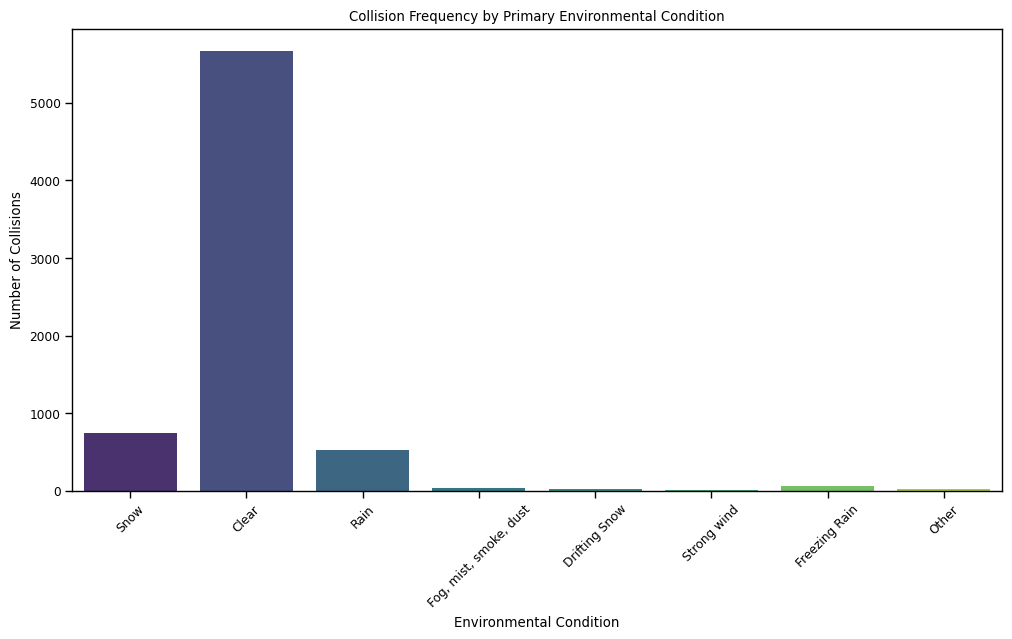

In [88]:
plt.figure(figsize=(12, 6))
sns.countplot(x='ENVIRONMENTCONDITION1', data=df_merged, palette="viridis")
plt.title("Collision Frequency by Primary Environmental Condition")
plt.xlabel("Environmental Condition")
plt.ylabel("Number of Collisions")
plt.xticks(rotation=45)
plt.show()

C:\Users\leocyr\AppData\Local\Temp\ipykernel_26768\1748254489.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='ACCIDENT_YEAR', data=adverse_conditions, palette="rocket")


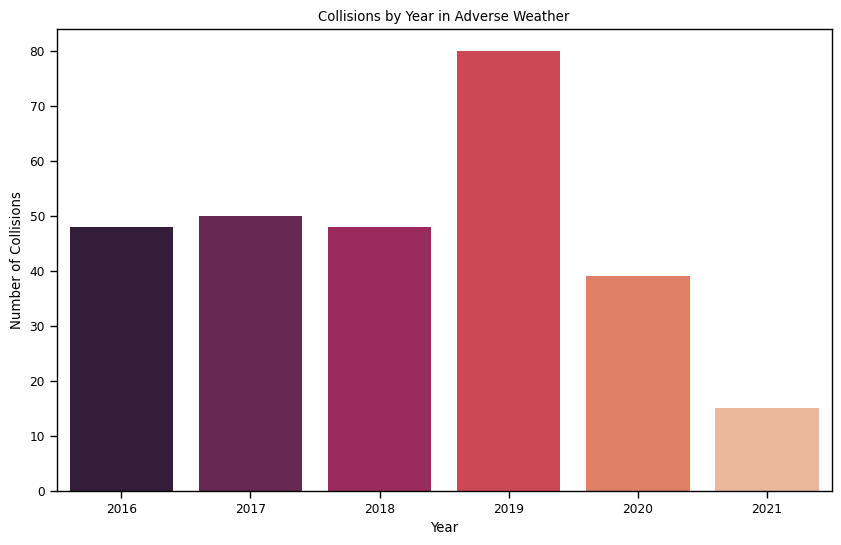

C:\Users\leocyr\AppData\Local\Temp\ipykernel_26768\1748254489.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='ACCIDENT_YEAR', data=df_merged, palette="rocket")


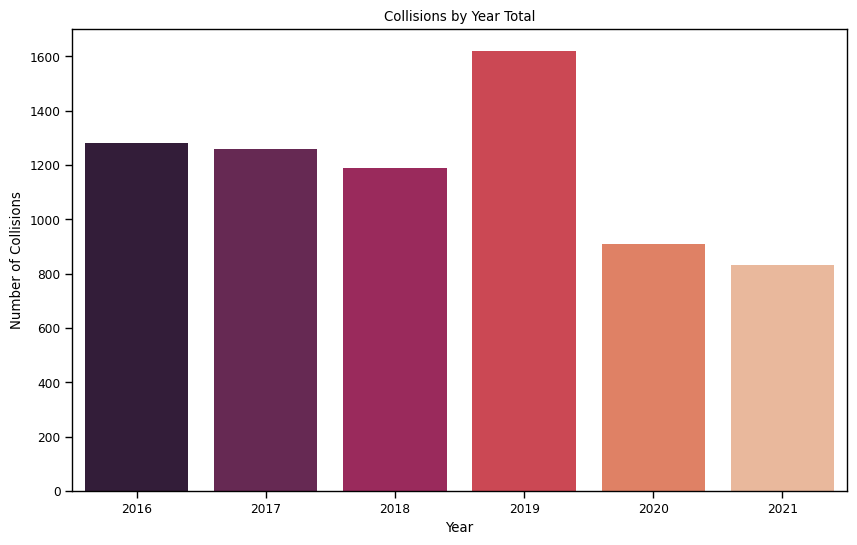

In [89]:
plt.figure(figsize=(10, 6))
sns.countplot(x='ACCIDENT_YEAR', data=adverse_conditions, palette="rocket")
plt.title("Collisions by Year in Adverse Weather")
plt.xlabel("Year")
plt.ylabel("Number of Collisions")
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(x='ACCIDENT_YEAR', data=df_merged, palette="rocket")
plt.title("Collisions by Year Total")
plt.xlabel("Year")
plt.ylabel("Number of Collisions")
plt.show()

Pedestrians, cyclists and motorcyclist analyzes


In [90]:
# Create bins for wind speed
df_merged['WIND_BIN'] = pd.cut(df_merged['WIND_SPEED'],
                               bins=[-1, 5, 10, 20, 40, 100],
                               labels=['<5 km/h', '5–10 km/h', '10–20 km/h', '20–40 km/h', '>40 km/h'])


# Create bins for temperature
df_merged['TEMP_BIN'] = pd.cut(
    df_merged['TEMP'],
    bins=[-40, -20, -10, 0, 5, 10, 20, 30, 50],
    labels=[
        '<-20°C', '-20 to -10°C', '-10 to 0°C', '0 to 5°C',
        '5 to 10°C', '10–20°C', '20–30°C', '>30°C'
    ]
)

In [91]:
#columns of interest from the dataset
columns_of_interest = ['PEDESTRIANINVOLVED','CYCLISTINVOLVED','MOTORCYCLISTINVOLVED',
                       'CLASSIFICATIONOFACCIDENT','VISIBILITY','PRECIP_AMOUNT','TEMP', 'WEATHER_ENG_DESC','TEMP_BIN',
                      'VISIBILITY_BIN','PRECIP_BIN','WIND_BIN']

df_interest=df_merged[columns_of_interest]

In [108]:
df_interest_pedestrian=df_interest.loc[df_interest['PEDESTRIANINVOLVED']=="True"]
df_interest_cycle=df_interest.loc[df_interest['CYCLISTINVOLVED']=="True"]
df_interest_motor=df_interest.loc[df_interest['MOTORCYCLISTINVOLVED']=="True"]

#number of collisions with Pedestrian, Cyclist, and Motor Cyclists based on temperature
ped_temp= df_interest_pedestrian['PEDESTRIANINVOLVED'].groupby(df_interest['TEMP_BIN']).size()
cyc_temp= df_interest_cycle['CYCLISTINVOLVED'].groupby(df_merged['TEMP_BIN']).size()
motor_temp= df_interest_motor['MOTORCYCLISTINVOLVED'].groupby(df_merged['TEMP_BIN']).size()
temp_collisions = pd.concat([ped_temp,cyc_temp,motor_temp],axis = 1)

#number of collisions with Pedestrian, Cyclist, and Motor Cyclists based on percipitation
ped_prep= df_interest_pedestrian['PEDESTRIANINVOLVED'].groupby(df_interest['PRECIP_BIN']).size()
cyc_prep= df_interest_cycle['CYCLISTINVOLVED'].groupby(df_merged['PRECIP_BIN']).size()
motor_prep= df_interest_motor['MOTORCYCLISTINVOLVED'].groupby(df_merged['PRECIP_BIN']).size()
prep_collisions = pd.concat([ped_prep,cyc_prep,motor_prep],axis = 1)

#number of collisions with Pedestrian, Cyclist, and Motor Cyclists based on visibility
ped_vis= df_interest_pedestrian['PEDESTRIANINVOLVED'].groupby(df_interest['VISIBILITY_BIN']).size()
cyc_vis= df_interest_cycle['CYCLISTINVOLVED'].groupby(df_merged['VISIBILITY_BIN']).size()
motor_vis= df_interest_motor['MOTORCYCLISTINVOLVED'].groupby(df_merged['VISIBILITY_BIN']).size()
vis_collisions = pd.concat([ped_vis,cyc_vis,motor_vis],axis = 1)

#number of collisions with Pedestrian, Cyclist, and Motor Cyclists based on wind
ped_wind= df_interest_pedestrian['PEDESTRIANINVOLVED'].groupby(df_interest['WIND_BIN']).size()
cyc_wind= df_interest_cycle['CYCLISTINVOLVED'].groupby(df_merged['WIND_BIN']).size()
motor_wind= df_interest_motor['MOTORCYCLISTINVOLVED'].groupby(df_merged['WIND_BIN']).size()
wind_collisions = pd.concat([ped_wind,cyc_wind,motor_wind],axis = 1)

C:\Users\leocyr\AppData\Local\Temp\ipykernel_26768\2849235726.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ped_temp= df_interest_pedestrian['PEDESTRIANINVOLVED'].groupby(df_interest['TEMP_BIN']).size()
C:\Users\leocyr\AppData\Local\Temp\ipykernel_26768\2849235726.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cyc_temp= df_interest_cycle['CYCLISTINVOLVED'].groupby(df_merged['TEMP_BIN']).size()
C:\Users\leocyr\AppData\Local\Temp\ipykernel_26768\2849235726.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to

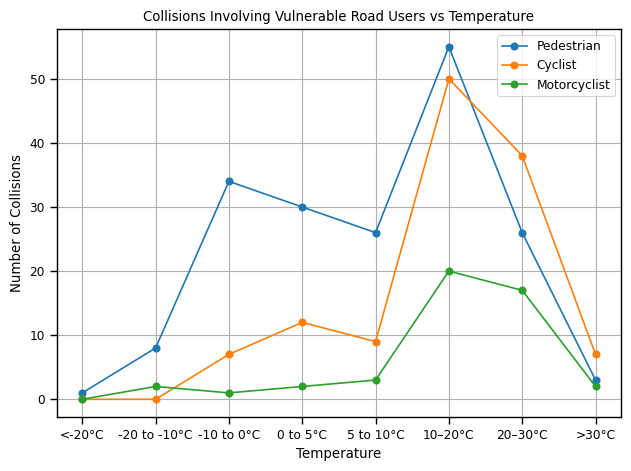

In [109]:
plt.plot(temp_collisions.index.astype(str),temp_collisions['PEDESTRIANINVOLVED'],marker='o', label='Pedestrian')
plt.plot(temp_collisions.index.astype(str),temp_collisions['CYCLISTINVOLVED'],marker='o', label='Cyclist')
plt.plot(temp_collisions.index.astype(str),temp_collisions['MOTORCYCLISTINVOLVED'],marker='o', label='Motorcyclist')

plt.title("Collisions Involving Vulnerable Road Users vs Temperature")
plt.xlabel('Temperature')
plt.ylabel('Number of Collisions')
plt.legend()
plt.grid(True)
plt.tight_layout()

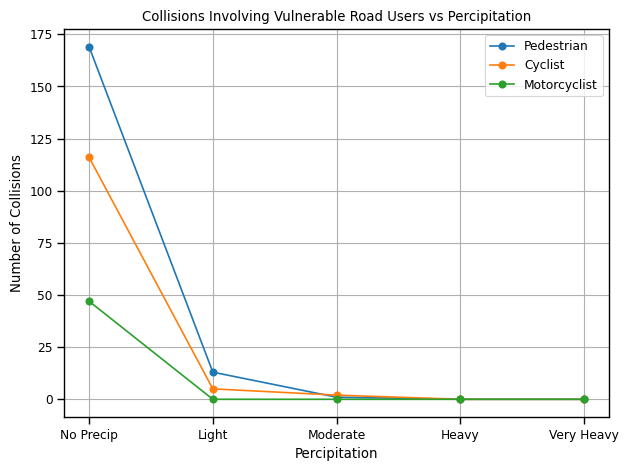

In [98]:
plt.plot(prep_collisions.index.astype(str),prep_collisions['PEDESTRIANINVOLVED'],marker='o', label='Pedestrian')
plt.plot(prep_collisions.index.astype(str),prep_collisions['CYCLISTINVOLVED'],marker='o', label='Cyclist')
plt.plot(prep_collisions.index.astype(str),prep_collisions['MOTORCYCLISTINVOLVED'],marker='o', label='Motorcyclist')

plt.title('Collisions Involving Vulnerable Road Users vs Percipitation')
plt.xlabel('Percipitation')
plt.ylabel('Number of Collisions')
plt.legend()
plt.grid(True)
plt.tight_layout()

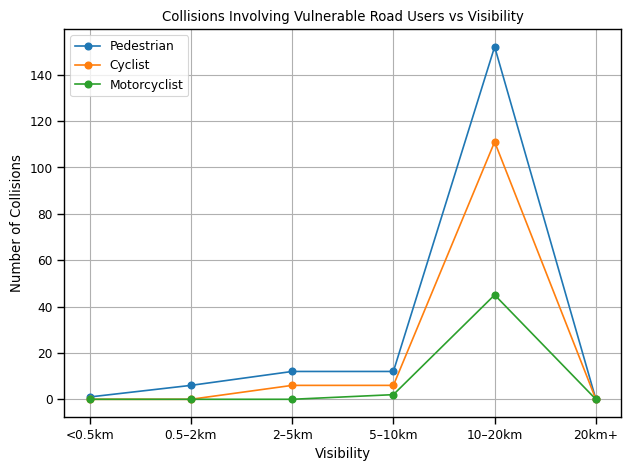

In [99]:
plt.plot(vis_collisions.index.astype(str),vis_collisions['PEDESTRIANINVOLVED'],marker='o', label='Pedestrian')
plt.plot(vis_collisions.index.astype(str),vis_collisions['CYCLISTINVOLVED'],marker='o', label='Cyclist')
plt.plot(vis_collisions.index.astype(str),vis_collisions['MOTORCYCLISTINVOLVED'],marker='o', label='Motorcyclist')

plt.title('Collisions Involving Vulnerable Road Users vs Visibility')
plt.xlabel('Visibility')
plt.ylabel('Number of Collisions')
plt.legend()
plt.grid(True)
plt.tight_layout()

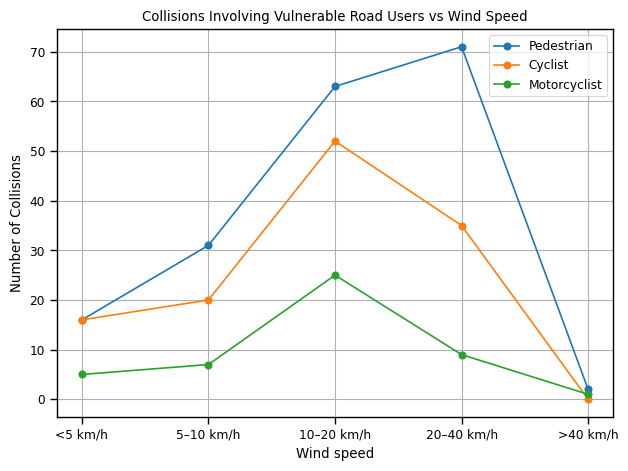

In [100]:
plt.plot(wind_collisions.index.astype(str),wind_collisions['PEDESTRIANINVOLVED'],marker='o', label='Pedestrian')
plt.plot(wind_collisions.index.astype(str),wind_collisions['CYCLISTINVOLVED'],marker='o', label='Cyclist')
plt.plot(wind_collisions.index.astype(str),wind_collisions['MOTORCYCLISTINVOLVED'],marker='o', label='Motorcyclist')

plt.title('Collisions Involving Vulnerable Road Users vs Wind Speed')
plt.xlabel('Wind speed')
plt.ylabel('Number of Collisions')
plt.legend()
plt.grid(True)
plt.tight_layout()

In [101]:
df_merged['PEDESTRIANINVOLVED'] =df_merged['PEDESTRIANINVOLVED'].map({'True': True, 'False': False})
df_merged['CYCLISTINVOLVED'] = df_merged['CYCLISTINVOLVED'].map({'True': True, 'False': False})
df_merged['MOTORCYCLISTINVOLVED'] = df_merged['MOTORCYCLISTINVOLVED'].map({'True': True, 'False': False})
df_merged['PEDESTRIANINVOLVED'] = df_merged['PEDESTRIANINVOLVED'].astype(int)
df_merged['CYCLISTINVOLVED'] = df_merged['CYCLISTINVOLVED'].astype(int)
df_merged['MOTORCYCLISTINVOLVED'] = df_merged['MOTORCYCLISTINVOLVED'].astype(int)
df_merged['DATE'] = pd.to_datetime(df_merged['ACCIDENT_DATETIME']).dt.date

daily_collisions = df_merged.groupby('DATE').agg({
    'PEDESTRIANINVOLVED': 'sum',
    'CYCLISTINVOLVED': 'sum',
    'MOTORCYCLISTINVOLVED': 'sum',
    'TEMP': 'mean',
    'PRECIP_AMOUNT': 'mean',
    'VISIBILITY': 'mean',
    'WIND_SPEED': 'mean'
}).reset_index()
daily_collisions.head()

,DATE,PEDESTRIANINVOLVED,CYCLISTINVOLVED,MOTORCYCLISTINVOLVED,TEMP,PRECIP_AMOUNT,VISIBILITY,WIND_SPEED
0,2016-01-01,0,0,0,-3.542857,0.0,10.585714,25.571429
1,2016-01-02,0,0,0,-1.800000,0.0,16.100000,34.000000
2,2016-01-03,0,0,0,-2.833333,0.0,16.100000,26.000000
3,2016-01-04,0,0,0,-13.860000,0.0,16.100000,15.800000
4,2016-01-05,0,0,0,-10.933333,0.0,13.966667,8.000000


In [102]:
correlation_matrix = daily_collisions[['PEDESTRIANINVOLVED', 'CYCLISTINVOLVED', 'MOTORCYCLISTINVOLVED',
                                       'TEMP', 'PRECIP_AMOUNT', 'VISIBILITY','WIND_SPEED']].corr()

print(correlation_matrix)

                      PEDESTRIANINVOLVED  CYCLISTINVOLVED  \
PEDESTRIANINVOLVED              1.000000         0.028923   
CYCLISTINVOLVED                 0.028923         1.000000   
MOTORCYCLISTINVOLVED            0.024438         0.034930   
TEMP                           -0.031264         0.146192   
PRECIP_AMOUNT                  -0.022812        -0.019967   
VISIBILITY                     -0.033040         0.057134   
WIND_SPEED                      0.030598        -0.041817   

                      MOTORCYCLISTINVOLVED      TEMP  PRECIP_AMOUNT  \
PEDESTRIANINVOLVED                0.024438 -0.031264      -0.022812   
CYCLISTINVOLVED                   0.034930  0.146192      -0.019967   
MOTORCYCLISTINVOLVED              1.000000  0.079448      -0.011596   
TEMP                              0.079448  1.000000       0.042915   
PRECIP_AMOUNT                    -0.011596  0.042915       1.000000   
VISIBILITY                        0.035904  0.269249      -0.174097   
WIND_SPEED    

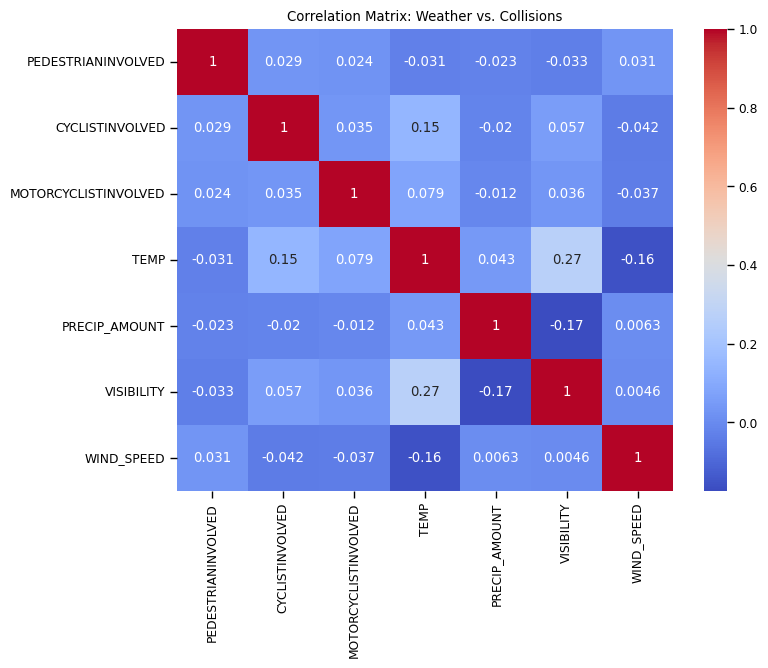

In [103]:
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True,cmap='coolwarm')
plt.title('Correlation Matrix: Weather vs. Collisions')
plt.show()